In [18]:
from langgraph.graph import MessagesState,StateGraph,START,END
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


import re
import httpx

from langchain_groq import ChatGroq

In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")
_set_env("GROQ_API_KEY")

In [11]:
def calculate(what:str) -> int:
    """
    Evaluate the equation  
    Args"
        what:equation string to evaluate
    """
    return eval(what)

def wikipedia(q:str):
    """
    Invoke the wikipedia service to get the required details
    Args"
        q:search string value which need to be searched
    """
    return httpx.get("https://en.wikipedia.org/w/api.php", params={
        "action": "query",
        "list": "search",
        "srsearch": q,
        "format": "json"
    }).json()["query"]["search"][0]["snippet"]

def other(nextaction:str):
    """
    fallback action when 
    Args"
        q:search string value which need to be searched
    """
    return nextaction
    

tools = [calculate,wikipedia,other]
llm = ChatGroq(model="llama3-8b-8192",temperature=0)
llm_with_tools = llm.bind_tools(tools)


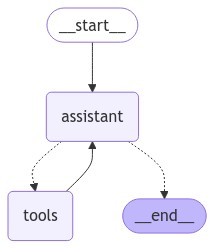

In [12]:
sys_msg = SystemMessage(content="You are a helpful assistant, tasked to answer the question which i ask")


def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [13]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 2, and finally divide by 5")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiply by 2, and finally divide by 5
================================== Ai Message ==================================
Tool Calls:
  calculate (call_1e6s)
 Call ID: call_1e6s
  Args:
    what: 3+4
================================= Tool Message =================================
Name: calculate

7
================================== Ai Message ==================================
Tool Calls:
  calculate (call_rmwc)
 Call ID: call_rmwc
  Args:
    what: 7*2
================================= Tool Message =================================
Name: calculate

14
================================== Ai Message ==================================
Tool Calls:
  calculate (call_zdkh)
 Call ID: call_zdkh
  Args:
    what: 14/5
================================= Tool Message =================================
Name: calculate

2.8
================================== Ai Message ==================================

In [14]:
messages = [HumanMessage(content="What is the sum of 3 and 5 and Explain speciality of India ")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the sum of 3 and 5 and Explain speciality of India 
================================== Ai Message ==================================
Tool Calls:
  calculate (call_s0rm)
 Call ID: call_s0rm
  Args:
    what: 3 + 5
  wikipedia (call_39j7)
 Call ID: call_39j7
  Args:
    q: specialty of India
================================= Tool Message =================================
Name: calculate

8
================================= Tool Message =================================
Name: wikipedia

A medical <span class="searchmatch">specialty</span> is a branch <span class="searchmatch">of</span> medical practice that is focused on a defined group <span class="searchmatch">of</span> patients, diseases, skills, or philosophy. Examples include
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_b6fn)
 Call ID: call_b6fn
  Args:
    q: specialty of India
=

In [15]:
messages = [HumanMessage(content="Explain speciality of India and What is the sum of 3 and 5 ")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Explain speciality of India and What is the sum of 3 and 5 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_gaxy)
 Call ID: call_gaxy
  Args:
    q: India
  calculate (call_z5eh)
 Call ID: call_z5eh
  Args:
    what: 3+5
================================= Tool Message =================================
Name: wikipedia

<span class="searchmatch">India</span>, officially the Republic of <span class="searchmatch">India</span> (ISO: Bhārat Gaṇarājya), is a country in South Asia. It is the seventh-largest country by area; the most populous
================================= Tool Message =================================
Name: calculate

8
================================== Ai Message ==================================

The Republic of India is a country in South Asia, known for its rich cultural heritage, diverse geography, and vibrant economy. It is 